In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, data_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, data_dim=784):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

class Encoder(nn.Module):
    def __init__(self, data_dim=784, latent_dim=100):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

import torch.autograd as autograd
autograd.set_detect_anomaly(True)

# Hyperparameters
latent_dim = 100
data_dim = 784  # 28 * 28 for MNIST images
batch_size = 64
num_epochs = 100
lr = 0.0002
num_clusters = 10

# Initialize models
generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)
encoder = Encoder(data_dim, latent_dim)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_E = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss functions
adversarial_loss = nn.BCELoss()
reconstruction_loss = nn.MSELoss()

# Means and standard deviations for each cluster
means = [torch.randn(latent_dim) for _ in range(num_clusters)]
std_devs = [torch.ones(latent_dim) for _ in range(num_clusters)]
means = torch.stack(means)
std_devs = torch.stack(std_devs)

def sample_z(batch_size, num_clusters, latent_dim, means, std_devs):
    cluster_indices = torch.randint(0, num_clusters, (batch_size,))
    one_hot = torch.nn.functional.one_hot(cluster_indices, num_clusters).float()
    selected_means = means[cluster_indices]
    selected_stds = std_devs[cluster_indices]
    epsilon = torch.randn(batch_size, latent_dim)
    z = selected_means + selected_stds * epsilon
    return z, one_hot

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17410009.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 482053.45it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3772790.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2656236.58it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:


for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real_data = imgs
        real_labels = torch.ones(batch_size, 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        z, one_hot = sample_z(batch_size, num_clusters, latent_dim, means, std_devs)
        fake_data = generator(z)
        fake_labels = torch.zeros(batch_size, 1)

        real_loss = adversarial_loss(discriminator(real_data), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(fake_data), real_labels)

        g_loss.backward()
        optimizer_G.step()

        # Train Encoder
        optimizer_E.zero_grad()
        encoded_real = encoder(real_data)
        reconstructed_data = generator(encoded_real)
        e_loss = reconstruction_loss(reconstructed_data, real_data)

        e_loss.backward()
        optimizer_E.step()

        if i % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} | Batch {i}/{len(train_loader)} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()} | E Loss: {e_loss.item()}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 143285467.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 16074269.35it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 72141232.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7990993.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 0/100 | Batch 0/938 | D Loss: 1.3410273790359497 | G Loss: 0.7139212489128113 | E Loss: 0.9213070273399353
Epoch 0/100 | Batch 100/938 | D Loss: 1.059840202331543 | G Loss: 1.1118464469909668 | E Loss: 0.39158427715301514
Epoch 0/100 | Batch 200/938 | D Loss: 0.836176335811615 | G Loss: 1.166800618171692 | E Loss: 0.33173155784606934
Epoch 0/100 | Batch 300/938 | D Loss: 0.6756010055541992 | G Loss: 2.023913621902466 | E Loss: 0.377661794424057
Epoch 0/100 | Batch 400/938 | D Loss: 0.7416391372680664 | G Loss: 1.7475924491882324 | E Loss: 0.31301170587539673
Epoch 0/100 | Batch 500/938 | D Loss: 0.6259264945983887 | G Loss: 2.694384813308716 | E Loss: 0.3352605402469635
Epoch 0/100 | Batch 600/938 | D Loss: 0.7543179988861084 | G Loss: 1.8690448999404907 | E Loss: 0.3115396499633789
Epoch 0/100 | Batch 700/938 | D Loss: 0.9757404923439026 | G Loss: 2.460379123687744 | E Loss: 0.2727506160736084
Epoch 0/100 | Batch 800/938 | D Loss: 0.823523223400116 | G Loss: 1.405415415763855 | 

In [1]:
# Lưu mô hình
import os
save_dir = '/content/drive/MyDrive/Colab_Notebooks/Main/saved-models-normal-mnist'

In [4]:
# save_dir = '/content/drive/MyDrive/Colab_Notebooks/Main/saved-models-normal-mnist'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

torch.save(generator.state_dict(), os.path.join(save_dir, 'generator.pth'))
torch.save(discriminator.state_dict(), os.path.join(save_dir, 'discriminator.pth'))
torch.save(encoder.state_dict(), os.path.join(save_dir, 'encoder.pth'))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMI: 0.4774
ARI: 0.3212
ACC: 0.5494


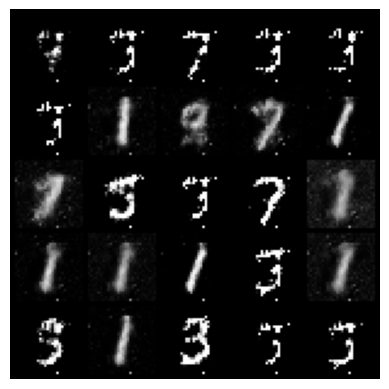

In [5]:
# Khởi tạo lại các mô hình (với các kiến trúc giống hệt như khi huấn luyện)
generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)
encoder = Encoder(data_dim, latent_dim)

# Tải lại trọng số cho các mô hình
generator.load_state_dict(torch.load(os.path.join(save_dir, 'generator.pth')))
discriminator.load_state_dict(torch.load(os.path.join(save_dir, 'discriminator.pth')))
encoder.load_state_dict(torch.load(os.path.join(save_dir, 'encoder.pth')))

# Đặt các mô hình về chế độ đánh giá (evaluation mode)
generator.eval()
discriminator.eval()
encoder.eval()

# Test models and extract latent representations
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def extract_latent_representations(encoder, data_loader):
    encoder.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in data_loader:
            encoded_imgs = encoder(imgs)
            latent_representations.append(encoded_imgs)
            labels.append(lbls)
    latent_representations = torch.cat(latent_representations)
    labels = torch.cat(labels)
    return latent_representations.cpu().numpy(), labels.cpu().numpy()

latent_representations, true_labels = extract_latent_representations(encoder, test_loader)
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

num_clusters = 10

# Apply KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
predicted_labels = kmeans.fit_predict(latent_representations)

def clustering_accuracy(true_labels, predicted_labels):
    matrix = contingency_matrix(true_labels, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(matrix, maximize=True)
    return matrix[row_ind, col_ind].sum() / matrix.sum()

# NMI
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
print(f"NMI: {nmi:.4f}")

# ARI
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"ARI: {ari:.4f}")

# ACC
acc = clustering_accuracy(true_labels, predicted_labels)
print(f"ACC: {acc:.4f}")

import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_generated_images(generator, latent_dim, num_images=25, device='cpu'):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, device=device)
        generated_images = generator(z).cpu()
        generated_images_grid = vutils.make_grid(generated_images, nrow=5, normalize=True)
        plt.imshow(generated_images_grid.permute(1, 2, 0))
        plt.axis('off')
        plt.show()

show_generated_images(generator, latent_dim)
